In [1]:
%pylab inline

import os
from string import replace
from styles import slides

Populating the interactive namespace from numpy and matplotlib


In [2]:
#READ TABLES

cat_m16 = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)
col_m16 = cat_m16["u_mag"]-cat_m16["r_mag"]
rsh_m16 = cat_m16["redshift"]
snr_m16 = genfromtxt("data/sample-obs/snr.txt", dtype=None, names=True)

gal2005 = genfromtxt("data/sample-obs/gal2005.txt", dtype=None, names=True)

match_m16_in_g05 = array([n in gal2005["input_file"] for n in cat_m16["input_file"]], dtype=bool)
compl_m16_in_g05 = array([n not in gal2005["input_file"] for n in cat_m16["input_file"]], dtype=bool)
del gal2005

cat_g05 = cat_m16[match_m16_in_g05]
col_g05 = col_m16[match_m16_in_g05]
rsh_g05 = rsh_m16[match_m16_in_g05]
snr_g05 = snr_m16[match_m16_in_g05]

cat_m16 = cat_m16[compl_m16_in_g05]
col_m16 = col_m16[compl_m16_in_g05]
rsh_m16 = rsh_m16[compl_m16_in_g05]
snr_m16 = snr_m16[compl_m16_in_g05]

print all(cat_g05["input_file"]==snr_g05["input_file"])&all(cat_m16["input_file"]==snr_m16["input_file"])

True


In [3]:
# MASKS FOR NEW SAMPLE
# mask to avoid aperture bias
rsh_m16_mask = rsh_m16>=0.05
rsh_g05_mask = rsh_g05>=0.05
# mask for g05 subsamples
SF_hSNR_g05_mask = (rsh_g05_mask&(col_g05< 2.22)&(snr_g05["snr_wall"]>15.0))
SF_hSNR_m16_mask = (rsh_m16_mask&(col_m16< 2.22)&(snr_m16["snr_wall"]>15.0))
Pa_hSNR_g05_mask = (rsh_g05_mask&(col_g05>=2.22)&(snr_g05["snr_wall"]>15.0))
# mask for cat subsample
SF_lSNR_m16_mask = (rsh_m16_mask&(col_m16< 2.22)&(snr_m16["snr_wall"]<=15.0))
Pa_lSNR_m16_mask = (rsh_m16_mask&(col_m16>=2.22)&(snr_m16["snr_wall"]<=15.0))

print "SF_hSNR_g05:", SF_hSNR_g05_mask.sum()
print "SF_hSNR_m16:", SF_hSNR_m16_mask.sum()
print "Pa_hSNR_g05:", Pa_hSNR_g05_mask.sum()
print "SF_lSNR_m16:", SF_lSNR_m16_mask.sum()
print "Pa_lSNR_m16:", Pa_lSNR_m16_mask.sum()
print
print "Total      :", SF_hSNR_g05_mask.sum()+SF_hSNR_m16_mask.sum()+Pa_hSNR_g05_mask.sum()+SF_lSNR_m16_mask.sum()+Pa_lSNR_m16_mask.sum()

SF_hSNR_g05: 3575
SF_hSNR_m16: 1719
Pa_hSNR_g05: 5887
SF_lSNR_m16: 5761
Pa_lSNR_m16: 482

Total      : 17424


In [4]:
colors = "#771144 #114477 #F1932D #AA4444 #F7EE55".split()
labels = ["SF hSNR g05 (%d)"%SF_hSNR_g05_mask.sum(),
          "SF hSNR m16 (%d)"%SF_hSNR_m16_mask.sum(),
          "SF lSNR m16 (%d)"%SF_lSNR_m16_mask.sum(),
          "Pa hSNR g05 (%d)"%Pa_hSNR_g05_mask.sum(),
          "Pa lSNR m16 (%d)"%Pa_lSNR_m16_mask.sum(),
         ]

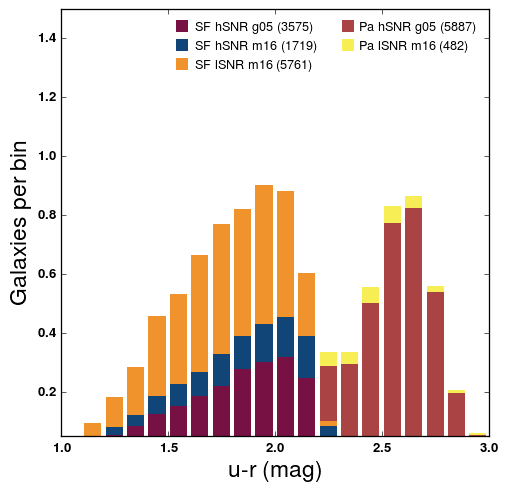

In [5]:
sub_col = [col_g05[SF_hSNR_g05_mask],
           col_m16[SF_hSNR_m16_mask],
           col_m16[SF_lSNR_m16_mask],
           col_g05[Pa_hSNR_g05_mask],
           col_m16[Pa_lSNR_m16_mask],
          ]
hist(sub_col, 20, (1,3), True, histtype="barstacked", color=colors, label=labels)
legend(loc=0, fontsize=10, ncol=2)
ylim(0.05, 1.5)

xlabel(r"u-r (mag)")
ylabel(r"Galaxies per bin")

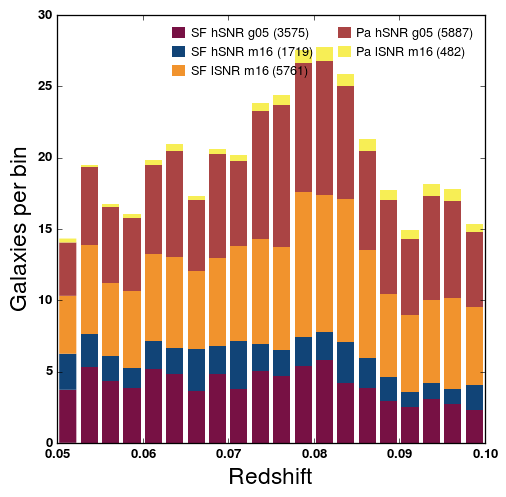

In [6]:
sub_rsh = [rsh_g05[SF_hSNR_g05_mask],
           rsh_m16[SF_hSNR_m16_mask],
           rsh_m16[SF_lSNR_m16_mask],
           rsh_g05[Pa_hSNR_g05_mask],
           rsh_m16[Pa_lSNR_m16_mask],
          ]
hist(sub_rsh, 20, (0.05,0.1), True, histtype="barstacked", color=colors, label=labels)
legend(loc=0, fontsize=10, ncol=2)

xlabel(r"Redshift")
ylabel(r"Galaxies per bin")

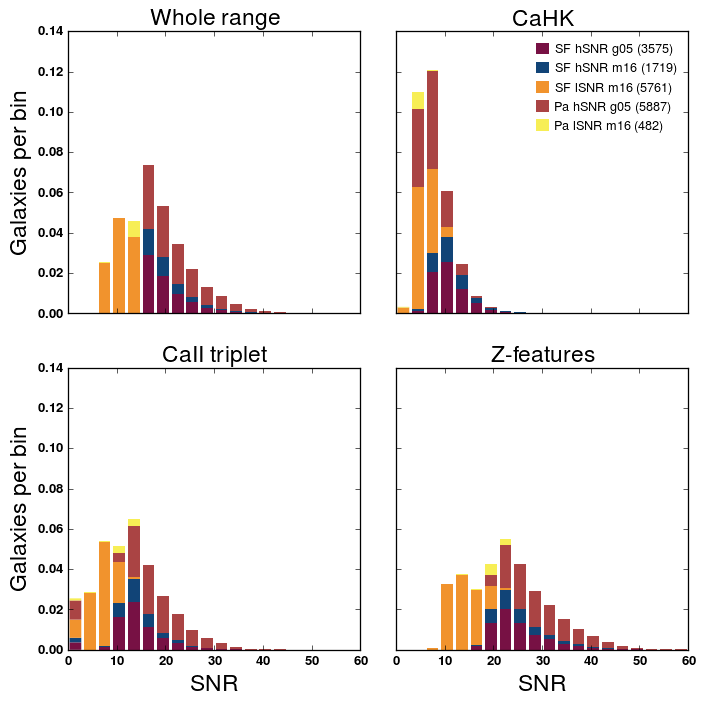

In [7]:
fig, axs = subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

sub_snr = lambda field: [snr_g05[field][SF_hSNR_g05_mask],
                         snr_m16[field][SF_hSNR_m16_mask],
                         snr_m16[field][SF_lSNR_m16_mask],
                         snr_g05[field][Pa_hSNR_g05_mask],
                         snr_m16[field][Pa_lSNR_m16_mask],
                        ]
fields = "snr_wall snr_CaHK snr_CaII snr_Zfea".split()
for field, ax in zip(fields, axs.ravel()):
    ax.set_title(field.lstrip("snr_").replace("wall", "Whole range").replace("Zfea", "Z-features").replace("CaII", "CaII triplet"))
    ax.hist(sub_snr(field), 20, (0.0,60.0), True, histtype="barstacked", color=colors, label=labels)

axs[0, 1].legend(loc=0, fontsize=10)
axs[1, 0].set_xlabel(r"SNR")
axs[1, 1].set_xlabel(r"SNR")
axs[0, 0].set_ylabel(r"Galaxies per bin")
axs[1, 0].set_ylabel(r"Galaxies per bin")

fig.tight_layout()

In [8]:
#WRITE TABLES
def convert(names, ID):
    return array(["processed_"+ID+"_"+name.replace(".fit", ".txt") for name in names], dtype=str)

# spec tables
od = os.path.expandvars("$phd/inputs/real_deal/spec/")
#savetxt(od+"spec_taita.txt",    convert(cat_g05["input_file"][SF_hSNR_g05_mask], "SPEC"), fmt="%s")
#savetxt(od+"spec_dulcinea.txt", convert(cat_m16["input_file"][SF_hSNR_m16_mask], "SPEC"), fmt="%s")
#savetxt(od+"spec_chapi.txt",    convert(cat_m16["input_file"][SF_lSNR_m16_mask], "SPEC"), fmt="%s")
#savetxt(od+"spec_ovcida2.txt",  convert(cat_g05["input_file"][Pa_hSNR_g05_mask], "SPEC"), fmt="%s")
#savetxt(od+"spec_danzon.txt",   convert(cat_m16["input_file"][Pa_lSNR_m16_mask], "SPEC"), fmt="%s")
# jpas tables
od = os.path.expandvars("$phd/inputs/real_deal/jpas/")
#savetxt(od+"jpas_taita.txt",    convert(cat_g05["input_file"][SF_hSNR_g05_mask], "JPAS"), fmt="%s")
#savetxt(od+"jpas_dulcinea.txt", convert(cat_m16["input_file"][SF_hSNR_m16_mask], "JPAS"), fmt="%s")
#savetxt(od+"jpas_chapi.txt",    convert(cat_m16["input_file"][SF_lSNR_m16_mask], "JPAS"), fmt="%s")
#savetxt(od+"jpas_ovcida2.txt",  convert(cat_g05["input_file"][Pa_hSNR_g05_mask], "JPAS"), fmt="%s")
#savetxt(od+"jpas_danzon.txt",   convert(cat_m16["input_file"][Pa_lSNR_m16_mask], "JPAS"), fmt="%s")
# nem_jpas tables
od = os.path.expandvars("$phd/inputs/real_deal/nem_jpas/")
#savetxt(od+"nem_jpas_taita.txt",    convert(cat_g05["input_file"][SF_hSNR_g05_mask], "nem_JPAS"), fmt="%s")
#savetxt(od+"nem_jpas_dulcinea.txt", convert(cat_m16["input_file"][SF_hSNR_m16_mask], "nem_JPAS"), fmt="%s")
#savetxt(od+"nem_jpas_chapi.txt",    convert(cat_m16["input_file"][SF_lSNR_m16_mask], "nem_JPAS"), fmt="%s")
#savetxt(od+"nem_jpas_ovcida2.txt",  convert(cat_g05["input_file"][Pa_hSNR_g05_mask], "nem_JPAS"), fmt="%s")
#savetxt(od+"nem_jpas_danzon.txt",   convert(cat_m16["input_file"][Pa_lSNR_m16_mask], "nem_JPAS"), fmt="%s")
# sdss tables
od = os.path.expandvars("$phd/inputs/real_deal/sdss/")
#savetxt(od+"sdss_taita.txt",    convert(cat_g05["input_file"][SF_hSNR_g05_mask], "SDSS"), fmt="%s")
#savetxt(od+"sdss_dulcinea.txt", convert(cat_m16["input_file"][SF_hSNR_m16_mask], "SDSS"), fmt="%s")
#savetxt(od+"sdss_chapi.txt",    convert(cat_m16["input_file"][SF_lSNR_m16_mask], "SDSS"), fmt="%s")
#savetxt(od+"sdss_ovcida2.txt",  convert(cat_g05["input_file"][Pa_hSNR_g05_mask], "SDSS"), fmt="%s")
#savetxt(od+"sdss_danzon.txt",   convert(cat_m16["input_file"][Pa_lSNR_m16_mask], "SDSS"), fmt="%s")